In [3]:
from transforms import affine_matrix_from_points
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader
from scipy.spatial import transform
import os

#flags that determine which ring cameras to use
use_fc, use_fl, use_sl, use_rl, use_rr, use_sr, use_fr = [1, 1, 0, 0, 0, 0, 0]

#path to the argoverse dataset
tracking_dataset_dir = '~/argoverse-tracking/sample/'
tracking_dataset_dir = os.path.expanduser(tracking_dataset_dir)

#log_index determines which log in the argoverse dataset directory to use
log_index = 0
argoverse_loader = ArgoverseTrackingLoader(tracking_dataset_dir)
log_id = argoverse_loader.log_list[log_index]
argoverse_data = argoverse_loader[log_index]

#colmap_output_dir points to the results from COLMAP
colmap_output_dir = '~/argoverse-tracking/sample2/output/'
colmap_output_dir = os.path.expanduser(colmap_output_dir)

#detection results directory
detection_output_dir = '~/argoverse-tracking/sample2/detector_output/'
detection_output_dir = os.path.expanduser(detection_output_dir)

#where to save computed traffic sign locations
location_output_dir = '~/argoverse-tracking/sample2/projection_output/'
location_output_dir = os.path.expanduser(location_output_dir)




#loading argoverse HD map
import matplotlib
import matplotlib.pyplot as plt
from visualize_30hz_benchmark_data_on_map import DatasetOnMapVisualizer
from argoverse.map_representation.map_api import ArgoverseMap
am = ArgoverseMap()
city_name = argoverse_data.city_name
dataset_dir = tracking_dataset_dir
experiment_prefix = 'visualization_demo'
use_existing_files = True
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
domv = DatasetOnMapVisualizer(dataset_dir, experiment_prefix, use_existing_files=use_existing_files, log_id=argoverse_data.current_log)



#read in colmap results
import numpy as np
poses_colmap = dict()
points_colmap = dict()
id2name_colmap = dict()
points3D = dict()

with open(colmap_output_dir + 'images.txt') as f:
    lines = f.read().splitlines()
for i,line in enumerate(lines):
    if line[0] == '#':
        continue
    else:
        if i % 2 == 0:
            fields = line.split(' ')
            image_name = fields[-1]
            image_id = int(fields[0])
            quat = fields[1:5]
            quatanion = np.array([float(q) for q in quat])
            trans = fields[5:8]
            translation = np.array([float(t) for t in trans])
            camera_id = int(fields[8])
            poses_colmap[image_name] = [quatanion, translation, image_id, camera_id]
            id2name_colmap[image_name] = image_id
        else:
            fields = line.split(' ')
            points_2d = np.array([float(pt) for pt in fields])
            points_colmap[image_name] = points_2d
            
with open(colmap_output_dir + 'points3D.txt') as f:
    lines = f.read().splitlines()
for i,line in enumerate(lines):
    if line[0] == '#':
        continue
    else: 
            fields = line.split(' ')
            points_attr = np.array([float(pt) for pt in fields])
            points3D[points_attr[0]] = np.array([points_attr[1],points_attr[2],points_attr[3]])
            

            
#read in argoverse data
import numpy.linalg as LA

calibration_ring_front_center = argoverse_data.get_calibration("ring_front_center")
calibration_ring_front_left = argoverse_data.get_calibration("ring_front_left")
calibration_ring_side_left = argoverse_data.get_calibration("ring_side_left")
calibration_ring_rear_left = argoverse_data.get_calibration("ring_rear_left")
calibration_ring_rear_right = argoverse_data.get_calibration("ring_rear_right")
calibration_ring_side_right = argoverse_data.get_calibration("ring_side_right")
calibration_ring_front_right = argoverse_data.get_calibration("ring_front_right")

argo_3d = []
colmap_3d = []
for idx in range(len(argoverse_data.image_list_sync['ring_front_center'])):
    city_to_egovehicle_se3 = argoverse_data.get_pose(idx)
    
    if use_fc:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_front_center.project_cam_to_ego(np.zeros((1,3))))[0]
    
        img_fc = argoverse_data.image_list_sync['ring_front_center'][idx]
        img_fc = img_fc.split('/')
        img_fc = img_fc[-2] + '/' + img_fc[-1]
        if img_fc in poses_colmap.keys():
            q = poses_colmap[img_fc][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_fc][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)
            
for idx in range(len(argoverse_data.image_list_sync['ring_front_center'])):
    city_to_egovehicle_se3 = argoverse_data.get_pose(idx)    
    if use_fr:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_front_right.project_cam_to_ego(np.zeros((1,3))))[0]
        img_fr = argoverse_data.image_list_sync['ring_front_right'][idx]
        img_fr = img_fr.split('/')
        img_fr = img_fr[-2] + '/' + img_fr[-1]
        if img_fr in poses_colmap.keys():
            q = poses_colmap[img_fr][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_fr][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)
            
    if use_fl:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_front_left.project_cam_to_ego(np.zeros((1,3))))[0]
        img_fl = argoverse_data.image_list_sync['ring_front_left'][idx]
        img_fl = img_fl.split('/')
        img_fl = img_fl[-2] + '/' + img_fl[-1]
        if img_fl in poses_colmap.keys():
            q = poses_colmap[img_fl][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_fl][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)
            
    if use_sl:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_side_left.project_cam_to_ego(np.zeros((1,3))))[0]
        img_sl = argoverse_data.image_list_sync['ring_side_left'][idx]
        img_sl = img_sl.split('/')
        img_sl = img_sl[-2] + '/' + img_sl[-1]
        if img_sl in poses_colmap.keys():
            q = poses_colmap[img_sl][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_sl][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)
            
    if use_sr:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_side_right.project_cam_to_ego(np.zeros((1,3))))[0]
        img_sr = argoverse_data.image_list_sync['ring_side_right'][idx]
        img_sr = img_sr.split('/')
        img_sr = img_sr[-2] + '/' + img_sr[-1]
        if img_sr in poses_colmap.keys():
            q = poses_colmap[img_sr][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_sr][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)
            
    if use_rl:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_rear_left.project_cam_to_ego(np.zeros((1,3))))[0]
        img_rl = argoverse_data.image_list_sync['ring_rear_left'][idx]
        img_rl = img_rl.split('/')
        img_rl = img_rl[-2] + '/' + img_rl[-1]
        if img_rl in poses_colmap.keys():
            q = poses_colmap[img_rl][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_rl][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)
            
    if use_rr:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_rear_right.project_cam_to_ego(np.zeros((1,3))))[0]
        img_rr = argoverse_data.image_list_sync['ring_rear_right'][idx]
        img_rr = img_rr.split('/')
        img_rr = img_rr[-2] + '/' + img_rr[-1]
        if img_rr in poses_colmap.keys():
            q = poses_colmap[img_rr][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_rr][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)

            
            
            
#compute 3d transformation from argoverse to colmap            
points_3d_argo = np.array(argo_3d)
points_3d_colmap = np.array(colmap_3d)
print(points_3d_argo.shape, points_3d_colmap.shape)

M = affine_matrix_from_points(points_3d_colmap[:,:].T, points_3d_argo[:,:].T, shear=False)
#M = affine_matrix_from_points(points_3d_colmap[0:10,:].T, points_3d_argo[0:10,:].T, shear=False)
points_3d_colmap_homo = np.vstack([points_3d_colmap.T, np.ones(points_3d_colmap.shape[0])])
ttt = M.dot(points_3d_colmap_homo)

(156, 3) (156, 3)


In [4]:
#read in detection results
import cv2 
import os
import numpy as np
boxes = np.load(detection_output_dir + log_id + '.npz',allow_pickle=True)
order = np.argsort(boxes['images_list'])
boxes_images_list = boxes['images_list'][order]
boxes_boxes_list = boxes['boxes_list'][order]
boxes_scores_list = boxes['scores_list'][order]
boxes_class_list = boxes['category_id_list'][order]
def check_inside(x1,y1,x2,y2,x,y):
    return x1 <= x and x <= x2 and y1 <= y and y <=y2
def bbox2argoverse(x1,y1,x2,y2,points_colmap,points3D,M,image_name):
    flag = False
    insider = []
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    for i in range(int( len(points_colmap[image_name]) // 3)):
        x = points_colmap[image_name][3*i]
        y = points_colmap[image_name][3*i + 1] 
        idx = points_colmap[image_name][3*i + 2] 
        if check_inside(x1,y1, x2, y2, x,y) and idx != -1:
            dist = (x - center_x) * (x - center_x) + (y - center_y) * (y - center_y)
            insider.append([x,y,idx,dist])
    if len(insider) <= 0:
        print("No feature points detected in the bounding box")
        flag = True
        return 0, flag, 0
    elif len(insider) > 3:
        print("More than 3 points detected in the bounding box")
        insider = np.array(insider)
        #print(insider)
        insider.view('f8,f8,f8,f8').sort(order=['f3'], axis=0)
        #print(insider)
        pts_colmap = np.zeros((3,3))
        pts_colmap[:,0] = points3D[insider[0,2]] #-1,2
        pts_colmap[:,1] = points3D[insider[1,2]] #-2,2
        pts_colmap[:,2] = points3D[insider[2,2]] #-3,2
        pts_homo = np.vstack([pts_colmap,np.ones(3)])
        pts_argo = M @ pts_homo
        return np.mean(pts_argo, axis=1), flag, np.mean(pts_colmap, axis = 1)
    else:
        print("Less than 3 points detected in the bounding box")
        pts_colmap = []
        for i,line in enumerate(insider):
              pts_colmap.append(points3D[insider[i][2]])
        pts_colmap = np.array(pts_colmap)
        pts_colmap = pts_colmap.T
        pts_homo = np.vstack([pts_colmap,np.ones(pts_colmap.shape[1])])
        pts_argo = M @ pts_homo
        return np.mean(pts_argo, axis=1), flag, np.mean(pts_colmap, axis = 1)

In [5]:
#compute traffic sign positions
marks = []
marks_col = []
names = []
scores = []
classes = []
for j in range(len(boxes_images_list)):
    image_name = 'ring_front_center/' + boxes_images_list[j]
    if os.path.exists(tracking_dataset_dir +log_id + '/' + image_name):
        im = cv2.imread(tracking_dataset_dir +log_id + '/'+ image_name)
        for cc,box in enumerate(boxes_boxes_list[j]):
            x1  = int(box[0] )#* 1200)
            y1 = int(box[1] )#* 1920)
            x2 = int(box[2] )#* 1200)
            y2 = int(box[3] )#* 1920)
            if (y2-y1) * (x2-x1) < 500: #1450
                continue
            if image_name not in points_colmap.keys():
                continue
            argo_box, flag, colmap_box =  bbox2argoverse(x1,y1,x2,y2,points_colmap,points3D,M,image_name)
            if flag: 
                continue
            #if len(marks) == 0:
            marks.append([argo_box[0], argo_box[1], argo_box[2]])
            names.append(image_name)
            scores.append(boxes_scores_list[j][cc])
            classes.append(boxes_class_list[j][cc])
            marks_col.append(colmap_box)
#marks = np.array(marks)

No feature points detected in the bounding box
No feature points detected in the bounding box
No feature points detected in the bounding box
More than 3 points detected in the bounding box
No feature points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding 

More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
No feature points detected in the bounding box
No feature points detected in the bounding box
Less than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
No feature points detected in the bounding box
No feature points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding 

In [6]:
db_marks = []
db_counts = []
db_names = []
db_classes = []

def check_adjacency(mark, db_mark):
    l2 = np.sqrt((mark[0] - db_mark[0])**2 + (mark[1] - db_mark[1])**2)
    dz = np.absolute(mark[2] - db_mark[2])
    return l2 < 0.6 and dz < 0.4

def check_category(category, db_class):
    return category == db_class

for i in range(len(marks)):
    new_sign = True
    mark = marks[i]
    if i == 0:
        db_marks.append(mark)
        db_classes.append(classes[i])
        db_names.append(names[i])
        db_counts.append(1)
    else:
        for cc in range(len(db_marks)):
            db_mark = db_marks[cc]
            if check_adjacency(mark, db_mark) and check_category(classes[i], db_classes[cc]):
                new_sign = False
                db_counts[cc] += 1
                db_marks[cc] = 1 * mark + 0 * db_mark
                break
        if new_sign:
            db_marks.append(mark)
            db_classes.append(classes[i])
            db_names.append(names[i])
            db_counts.append(1)

marks = np.array(db_marks)
order = np.argsort(marks[:, 0])
print(order)
db_marks = np.array(db_marks)[order]
db_classes = np.array(db_classes)[order]
db_names = np.array(db_names)[order]
db_counts = np.array(db_counts)[order]
print(np.sort(marks.view('f8,f8,f8'), order=['f0'], axis=0))


for i in range(len(db_marks)):
    print(db_marks[i], db_classes[i], db_names[i], db_counts[i])
print(len(db_marks))

[20 17 19 13 12 15  2 16 18  1  3 14  9  4 11 10  0  7  6  8  5]
[[(2576.08101101, 1199.09703696, 16.49887731)]
 [(2589.31012735, 1205.72015614, 17.51022144)]
 [(2589.34219527, 1205.66718961, 17.02531521)]
 [(2596.8833383 , 1191.60758704, 20.82102332)]
 [(2597.89818131, 1192.48768664, 20.10728931)]
 [(2598.15849598, 1192.72812317, 19.92565796)]
 [(2598.77548975, 1193.89470479, 21.829439  )]
 [(2599.54815885, 1198.55306603, 20.12784844)]
 [(2599.57324317, 1198.47995138, 19.72473012)]
 [(2607.40562423, 1223.21491884, 18.13321268)]
 [(2607.47383197, 1204.04525999, 21.24501157)]
 [(2607.6082839 , 1223.06999855, 17.06211994)]
 [(2616.01359854, 1214.30841455, 21.41689872)]
 [(2616.29632059, 1213.99998821, 20.65506912)]
 [(2621.17911014, 1235.42716012, 16.85858402)]
 [(2621.24977727, 1235.32736113, 16.36928504)]
 [(2630.87936547, 1244.47467057, 17.42338999)]
 [(2630.99311724, 1244.51958524, 16.78888518)]
 [(2631.01543658, 1244.27158608, 16.23551428)]
 [(2639.50945263, 1235.46937879, 19.002871

In [7]:
x1 = [2616.29632059,1213.99998821]
x2 = [2616.56821749,1214.3288324]
print(np.sqrt((x1[1]-x2[1])**2 + (x1[0]-x2[0])**2))

0.4266924249693159


In [8]:
#save detected traffic signs 
argo_mark_poses = np.array(marks)
colmap_mark_poses = np.array(marks_col)
categories = np.array(classes)
scores = np.array(scores)
colmap2argo = M
colmap_camera_poses = points_3d_colmap
argo_camera_poses = points_3d_argo

np.savez(location_output_dir + log_id+'_projected.npz', 
         argo_mark_poses=argo_mark_poses, 
         colmap_mark_poses=colmap_mark_poses,
         categories=categories,
         scores=scores,
         colmap2argo=colmap2argo,
         argo_camera_poses=argo_camera_poses,
         colmap_camera_poses=colmap_camera_poses
        )

(4, 156) (156, 3)
0.06950603208036611


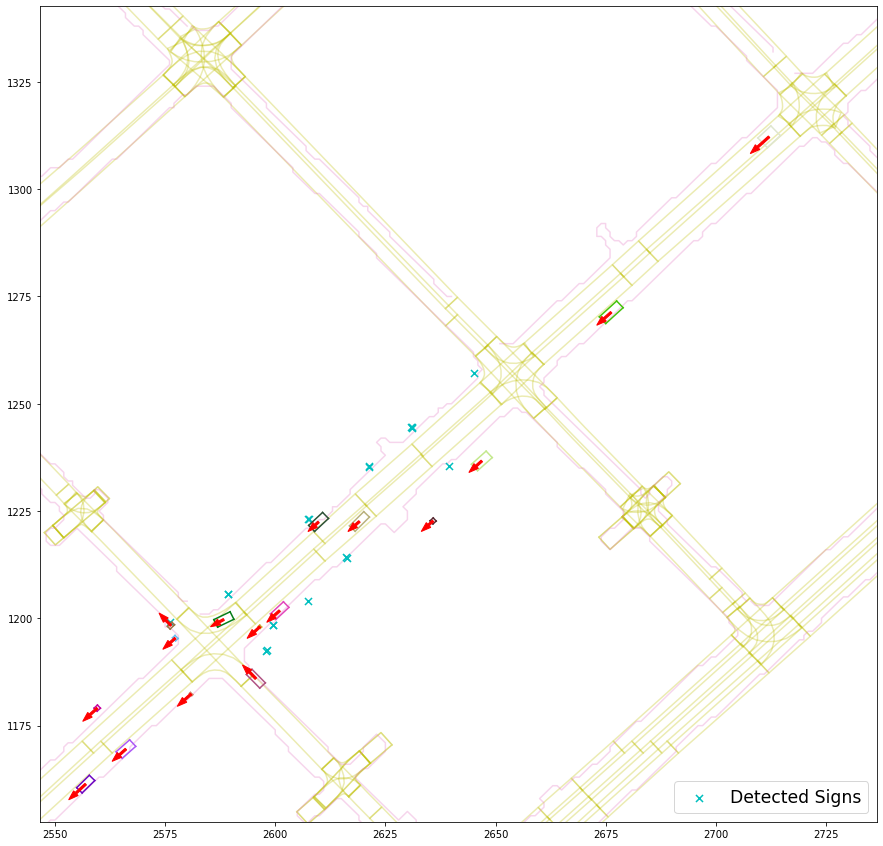

In [20]:
import copy

#R, t = svd_rt(points_3d_colmap_scaled.T[:,:10], points_3d_argo.T[:,:10])
#t = t.reshape(-1)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
#xcenter = (points_3d_argo[0,0] + points_3d_argo[-1,0])/2 #+ 15
#ycenter = (points_3d_argo[0,1] + points_3d_argo[-1,1])/2#+ 15

xcenter = points_3d_argo[20,0]
ycenter = points_3d_argo[20,1]
   
xmin = xcenter - 100  # 150 #70
xmax = xcenter + 90 # 150 #70
ymin = ycenter - 100  # 150 #70
ymax = ycenter + 90  # 150 #70

#xmin = xcenter - 10  # 150
#xmax = xcenter + 10 # 150
#ymin = ycenter - 10  # 150
#ymax = ycenter + 10  # 150

#2.59058920e+03 1.20444779e+03

#2.59058802e+03 1.20428979e+03
#2.58554503e+03 1.18528893e+03
points_3d_colmap_h = np.vstack([points_3d_colmap.T, np.ones(points_3d_colmap.shape[0])])
print(points_3d_colmap_h.shape,points_3d_colmap.shape)
projected = M @ points_3d_colmap_h

#ax.scatter(points_3d_argo[2:8,0], points_3d_argo[2:8,1], 50, color="g", marker=".", zorder=2, label='ground truth front center camera poses')
#ax.scatter(projected[0,2:8], projected[1,2:8], 50, color="blue", marker="x", zorder=2, label="Projected COLMAP front center camera poses")

# Nov 06 Comment These
#ax.scatter(points_3d_argo[:,0], points_3d_argo[:,1], 50, color="g", marker=".", zorder=2, label='ground truth front center camera poses')
#ax.scatter(projected[0,:], projected[1,:], 50, color="blue", marker="x", zorder=2, label="Projected COLMAP front center camera poses")
# Dec 02 Comment These
#ax.scatter(marks[:,0], marks[:,1] , 50, color="c", marker="x", zorder=2, label="Detected Signs")

db_marks[6, 0] = 0
db_marks[6, 1] = 0
db_marks[3, 0] = 0
db_marks[3, 1] = 0
ax.scatter(db_marks[:,0], db_marks[:,1] , 50, color="c", marker="x", zorder=2, label="Detected Signs")


##label gt
#ax.scatter(our[:,0], our[:,1], 50, color="r", marker="x", zorder=2, label="Our Results")
#ax.scatter(gt[:,0], gt[:,1], 50, color="g", marker="x", zorder=2, label="GT Positions")

a = np.sum((projected[0:3,:] - points_3d_argo.T)**2,axis=0)
rmse = np.mean(a)
rmse = np.sqrt(rmse)
print(rmse)




#ax.scatter(marks2[:,0], marks2[:,1] , 50, color="g", marker="x", zorder=2, label="Tracked Signs")
#ax.scatter([triangulated[0]], [triangulated[1]], 50, color="r", marker="x", zorder=2, label="Triangulated Sign Position")
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
local_lane_polygons = am.find_local_lane_polygons([xmin, xmax, ymin, ymax], city_name)
local_das = am.find_local_driveable_areas([xmin, xmax, ymin, ymax], city_name)

ax.legend(fontsize='xx-large')

domv.render_bev_labels_mpl( 
    city_name,
    ax,
    "city_axis",
    None,
    copy.deepcopy(local_lane_polygons),
    copy.deepcopy(local_das),
    argoverse_loader.log_list[log_index],
    argoverse_data.lidar_timestamp_list[100],
    city_to_egovehicle_se3,
    am,

)

plt.savefig("rigid_transform.png")